# Feature Selection Notebook:

This notebook contains the code for preprocessing and feature selection.

We run the `preprocess_and_train` function from `preptrain.py`; the steps of that function are described below.

We same the selected features to a separate .csv file, `df_selected.csv`, which we use in our models in the `Models.ipynb`.

## Explanation of the `preprocess_and_train` function:

### Defining Numeric Columns (Excluding "Pos"):

This step identifies the numeric columns in the input DataFrame `df`, excluding the column labeled "Pos" for player position.

### Splitting Data into Training and Testing Sets:

Splits the input data into training and testing sets using the `train_test_split` function from `scikit-learn`.

### Defining Preprocessing Steps:

Defines the preprocessing steps using pipelines. For numeric features, we impute missing values with the median value and then scale the features using standardization (subtracting the mean and dividing by the standard deviation). For categorical features (specifically "Pos"), we apply one-hot encoding while ignoring unknown categories.

### Preprocessing Training and Testing Data:

Applies the preprocessing separately to the training and testing datasets using the `fit_transform` and `transform` methods of the `ColumnTransformer`.

### Extracting Feature Names:

Extracts the feature names from the `ColumnTransformer` object. This step removes any prefixes such as "num__" or "cat__".

### Filter Method - SelectKBest:

Uses SelectKBest with ANOVA F-value to select the top 10 features based on their scores. These scores represent the strength of the relationship between each feature and the target variable.

### Wrapper Method 1 - Random Forest Feature Importance:

Trains a Random Forest Regressor on the preprocessed training data to determine feature importance and selects the top 10 features with the highest feature importance scores.

### Embedded Method - L1-based feature selection using Lasso:

LassoCV (Lasso Cross-validation) is employed to perform L1-based feature selection. It iteratively fits Lasso models with different regularization strengths (alphas) and selects features based on non-zero coefficients.

### Performs Principal Component Analysis (PCA):

Performs PCA to reduce the dimensionality of the data and select the top 10 principal components as features.

### Stability Selection with Lasso:
Uses Stability Selection with Lasso to select features. We apply LassoCV within SelectFromModel to select features based on stability across multiple Lasso models.

### Recursive Feature Elimination with Cross-Validation (RFECV):

Applies RFECV, a wrapper method that recursively selects features by recursively training the model and selecting the best-performing subset of features through cross-validation.

### Wrapper Method 2 - Gradient Boosting Machine Feature Importance

Trains a Gradient Boosting Machine model on the preprocessed training data to determine feature importance and selects the top 10 features with the highest feature importance scores.

### Embedded Method 2 - Support Vector Regressor

Uses Support Vector Regressor (SVR) within SelectFromModel to perform embedded feature selection. Features are selected based on the coefficients obtained from the SVR model.

### Preparing Final Data for Training:

Extracts the selected features from the preprocessed training and testing data and prepares the final datasets (X_train, X_test, y_train, y_test) for model training and evaluation.

### Returning Results:

The function returns various components: the selected features from each method (features_filter, features_wrapper, features_embedded), the names of the selected features (feature_names), and the preprocessed training and testing data along with their corresponding labels.

In [1]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, SelectFromModel, RFE, RFECV, mutual_info_regression
from sklearn.cluster import FeatureAgglomeration
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from scipy.stats import randint
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np

import os
os.chdir('/Users/wyattscott/Documents/DS5110/Project')

from pltcorrheatmap import plot_corr_heatmap
from preptrain import preprocess_and_train

In [6]:
# Load the data
df = pd.read_csv('df_clean.csv')
df_last = pd.read_csv('df_last.csv')
label_col_name = "mvp_share"
labels = df.pop(label_col_name)
stratify = df.pop("Rank")

In [3]:
# Call the function to preprocess the data and perform feature selection
(features_filter, features_wrapper, 
            features_embedded, features_pca,
            features_stability_selection, feature_names,
            features_rfecv, features_wrapper_gbm,
            features_embedded_svr,
            X_train, X_test, y_train, y_test) = preprocess_and_train(df, df_last, labels)

In [4]:
# Print selected features
print("Features - Filter Method (ANOVA F-value):", features_filter)
print("Features - Random Forest:", features_wrapper)
print("Features - Embedded Method (Lasso):", features_embedded)
print(f"PCA 1: {features_pca[0]}")
print("Features - Stability Selection:", features_stability_selection)
print("Features - RFECV:", features_rfecv)
print("Features - GBM:", features_wrapper_gbm)
print("Features - SVR:", features_embedded_svr)

Features - Filter Method (ANOVA F-value): ['FT', 'FTA', 'PTS', 'PER', 'OWS', 'WS', 'WS/48', 'OBPM', 'BPM', 'VORP']
Features - Random Forest: ['WS', 'PER', 'VORP', 'Rk_Season', 'Rk_Conference', 'Overall', 'DWS', 'BPM', 'USG%', 'FGA']
Features - Embedded Method (Lasso): ['VORP', 'Trp Dbl']
PCA 1: ['OBPM', 'OWS', 'FT', '2P', 'FTA', 'VORP', 'FG', 'PTS', 'PER', 'WS']
Features - Stability Selection: ['VORP', 'Trp Dbl']
Features - RFECV: ['BPM', 'WS', 'BLK%', 'AST%', 'TOV%', 'DWS', 'OWS', 'PF', 'Pos_PG', 'DBPM']
Features - GBM: ['WS', 'PER', 'Rk_Season', 'VORP', 'Rk_Conference', 'Overall', 'USG%', 'DWS', 'AST', 'TOV']
Features - SVR: ['WS', 'OWS', 'DWS', 'VORP', 'WS/48', 'PER', 'Rk_Conference', 'FTA', 'Trp Dbl', 'FT']


In [5]:
PCA1 = ['OBPM', 'OWS', 'FT', '2P', 'FTA', 'VORP', 'FG', 'PTS', 'PER', 'WS']

# Combine selected features from different methods into a single list
combined_features = (features_filter + features_wrapper + features_embedded + PCA1 +
                     features_stability_selection + features_rfecv + features_wrapper_gbm + features_embedded_svr)

# Calculate feature importance scores
feature_scores = {}
for feature in combined_features:
    feature_scores[feature] = feature_scores.get(feature, 0) + 1

# Rank features based on importance scores
ranked_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

# Select top 10 features
top_10_features = [feature for feature, _ in ranked_features[:10]]

# Print the top 10 features
print("Top 10 features:")
for i, (feature, score) in enumerate(ranked_features[:10], start=1):
    print(f"{i}. {feature}: {score}")

Top 10 features:
1. VORP: 7
2. WS: 6
3. PER: 5
4. OWS: 4
5. DWS: 4
6. FT: 3
7. FTA: 3
8. BPM: 3
9. Rk_Conference: 3
10. Trp Dbl: 3


## Selected Features:

- VORP = Value Over Replacement Player -- $[BPM - (-2.0)]*$(% of possessions played)$ * \frac{team games}{82}$

- WS = Win Shares

- PER = Player Efficiency Rating (see <a href="https://www.basketball-reference.com/about/per.html">Calculating PER</a> for the formula)

- FT = Free Throws

- BPM = Box Plus/Minus (see <a href="https://www.basketball-reference.com/about/bpm2.html">About Box Plus/Minus (BPM)</a> for the formula)

- Rk_Conference =

- Trp Dbl = Triple Double (player gets 3 stats in the double-digits in a single game)  
  
- USG% = Usage Percentage -- ($100 * \frac{((FGA + 0.44 * FTA + TOV) * (Tm MP / 5))}{(MP * (Tm FGA + 0.44 * Tm FTA + Tm TOV))}$)
  
- AST = Assists
  
- 2P% = 2-Point Field Goal Percentage -- $\frac{2P}{2PA}$

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


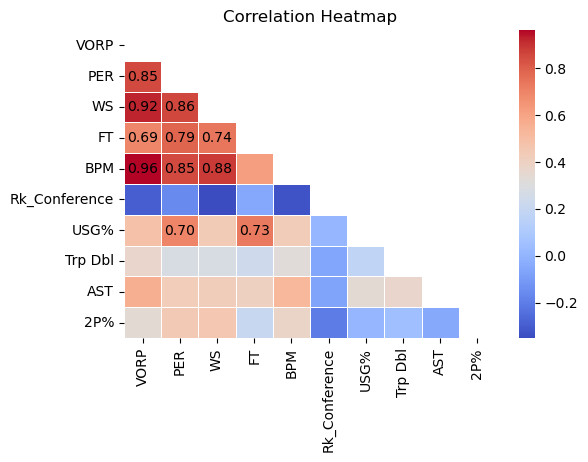

In [9]:
# Select only the columns corresponding to the top 10 features
selected_features = ['VORP', 'PER', 'WS', 'FT', 'BPM', 'Rk_Conference', 'USG%', 'Trp Dbl', 'AST', '2P%']
df_check_selected = df[selected_features]
corr_matrix = df_check_selected.corr()

plot_corr_heatmap(corr_matrix, selected_features, threshold=0.65)

In [10]:
df_selected = df[selected_features]
df_selected.to_csv('df_selected.csv', index=False)